In [1]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import numpy as np
import os
import requests
import gzip
import shutil
import glob
import folium
import matplotlib.patches as mpatches
from scipy import stats

%matplotlib inline
%config InlineBackend.figure_format ='retina'

sharedFolder = '/work/group/egodat/reu23_clark/'
dataFolder = sharedFolder + 'data/'

statesShp = geopandas.read_file(dataFolder + "/cb_2018_us_state_500k.zip").to_crs(3857)
statesShp = statesShp[['GEOID', 'STUSPS', 'NAME', 'geometry']]

def plotUS():
    ax = statesShp.plot(figsize=(20, 10), color='#e4e4e4', edgecolor='black', linewidth=2)
    ax.axis('equal')
    plt.xlim(-1.5e7, -0.7e7)
    plt.ylim(2.5e6, 7e6)
    return ax

def plotTX():
    ax = statesShp[statesShp['STUSPS'] == 'TX'].plot(figsize=(10, 10), color='#e4e4e4', edgecolor='black', linewidth=2)
    ax.axis('equal')
    plt.xlim(-1.23e7, -1e7)
    plt.ylim(2.5e6, 5e6)
    return ax

def plotDFW():
    ax = statesShp[statesShp['STUSPS'] == 'TX'].plot(figsize=(10, 10), color='#e4e4e4', edgecolor='black', linewidth=2)
    ax.axis('equal')
    plt.xlim(-1.12e7, -1.04e7)
    plt.ylim(3.7e6, 4.1e6)
    return ax

In [2]:
df10 = pd.read_pickle(dataFolder + "combined2010.pkl")
df15 = pd.read_pickle(dataFolder + "combined2015.pkl")
df19 = pd.read_pickle(dataFolder + "combined2019.pkl")
df20 = pd.read_pickle(dataFolder + "combined2020.pkl")
df21 = pd.read_pickle(dataFolder + "combined2021.pkl")

In [3]:
goodVars = [
    'RDOMESTICMIGw',
    'Median_Income',
    'Pct_BS_Above',
]
allVars = ['NAME', 'CBSA', 'geometry', 'metro', 'micro', 'liminal', 'POPESTIMATE'] + goodVars

In [4]:
df = df21[allVars].copy()

In [5]:
scoreTot = np.zeros_like(df['RDOMESTICMIGw'].values)

for var in goodVars:
    df['z-' + var] = stats.zscore(df[var])
    scoreTot += stats.zscore(df[var])

df['score'] = scoreTot / len(goodVars)

In [6]:
dfTx = df[df['NAME'].str.contains(', TX')]
dfTx[dfTx['liminal']].sort_values('RDOMESTICMIGw', ascending=False).drop(columns=['CBSA', 'metro', 'micro', 'liminal', 'geometry'])

,NAME,POPESTIMATE,RDOMESTICMIGw,Median_Income,Pct_BS_Above,z-RDOMESTICMIGw,z-Median_Income,z-Pct_BS_Above,score
339,"Granbury, TX",64222,41.205802,45579.0,0.303971,3.384366,1.119145,0.556158,1.686556
728,"Rockport, TX",24510,35.137820,31357.0,0.247695,2.842223,-1.346798,-0.052791,0.480878
55,"Bonham, TX",36569,27.261941,42387.0,0.186320,2.138553,0.565686,-0.716925,0.662438
142,"Fredericksburg, TX",27297,26.282323,35377.0,0.352266,2.051029,-0.649773,1.078749,0.826669
322,"Athens, TX",83667,20.757320,36214.0,0.182067,1.557398,-0.504646,-0.762942,0.096603
400,"Huntsville, TX",77977,20.167709,37223.0,0.200619,1.504719,-0.329696,-0.562197,0.204276
445,"Kerrville, TX",53161,16.580213,36505.0,0.291419,1.184195,-0.454189,0.420328,0.383444
112,"Corsicana, TX",53591,16.013808,32444.0,0.166493,1.133590,-1.158323,-0.931463,-0.318732
820,"Stephenville, TX",43378,14.618600,40620.0,0.308501,1.008935,0.259307,0.605172,0.624471
151,"Gainesville, TX",42244,13.582505,42515.0,0.220449,0.916365,0.587880,-0.347618,0.385542


In [12]:
df[df['liminal']].sort_values('score', ascending=False).drop(columns=['metro', 'micro', 'liminal', 'geometry']).head(25)

,NAME,CBSA,POPESTIMATE,RDOMESTICMIGw,Median_Income,Pct_BS_Above,z-RDOMESTICMIGw,z-Median_Income,z-Pct_BS_Above,score
375,"Heber, UT",25720,79266,17.928883,49488.5,0.505873,1.304692,1.797010,2.740896,1.947533
339,"Granbury, TX",24180,64222,41.205802,45579.0,0.303971,3.384366,1.119145,0.556158,1.686556
882,"Vineyard Haven, MA",47240,21097,25.364386,43314.0,0.460530,1.969016,0.726418,2.250245,1.648560
819,"Steamboat Springs, CO",44460,25091,7.739235,48441.0,0.508050,0.394298,1.615385,2.764456,1.591380
425,"Jefferson, GA",27600,80286,44.796626,42624.0,0.250030,3.705188,0.606780,-0.027529,1.428146
114,"Corvallis, OR",18700,96017,8.433022,42573.0,0.533632,0.456285,0.597937,3.041270,1.365164
202,"Easton, MD",20660,37626,12.118287,47406.0,0.409930,0.785545,1.435927,1.702721,1.308064
216,"Ellensburg, WA",21260,45499,19.365807,46360.0,0.353231,1.433074,1.254562,1.089187,1.258941
448,"Kill Devil Hills, NC",28620,37826,25.181431,37900.0,0.401750,1.952670,-0.212311,1.614206,1.118188
205,"Edwards, CO",20780,55727,-5.675246,46570.0,0.509190,-0.804217,1.290974,2.776785,1.087847


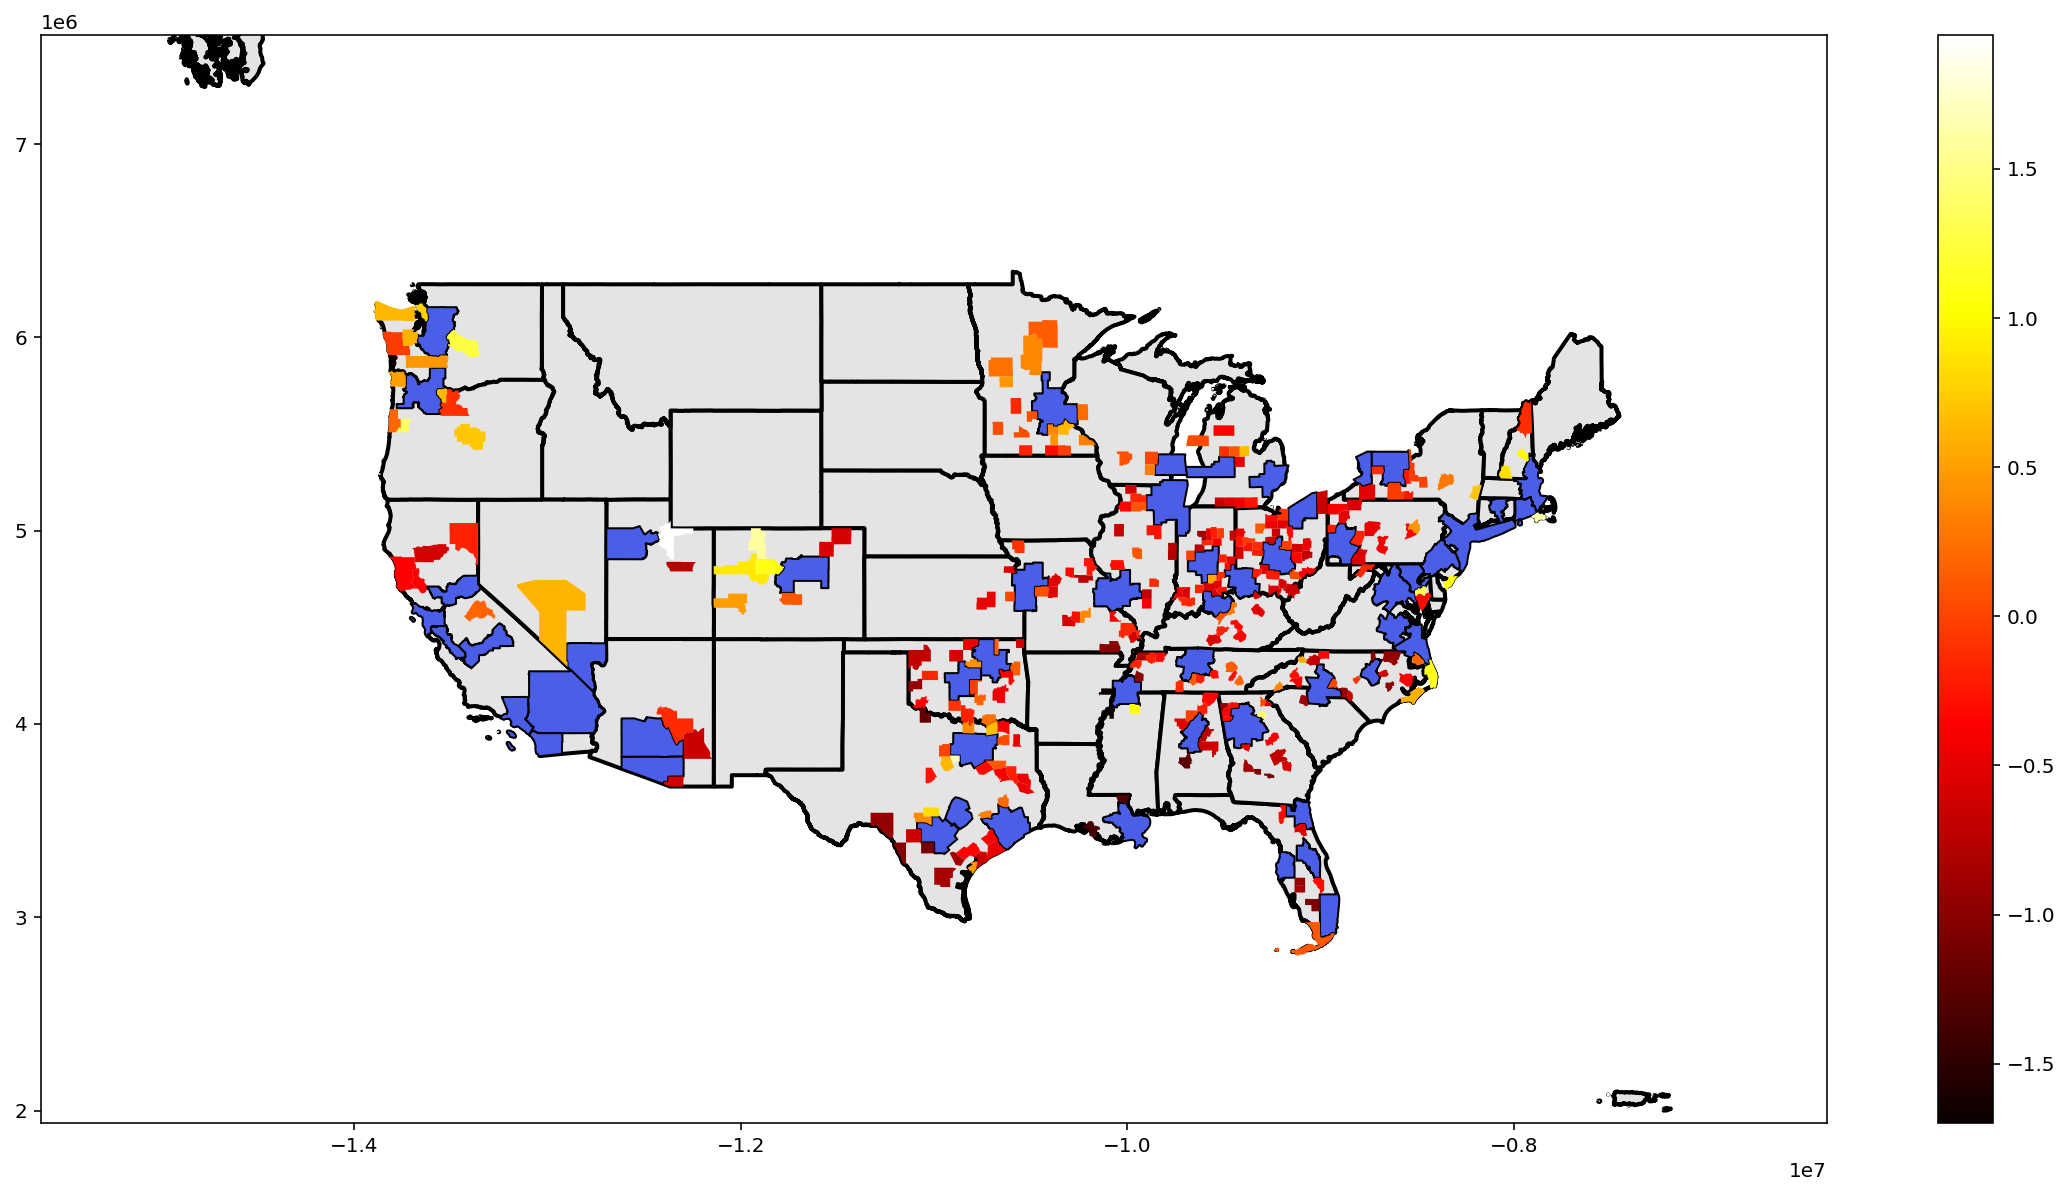

In [23]:
ax = plotUS()
df[df['metro']].plot(ax=ax, color="#4a5ee7", edgecolor="black", linewidth=1, label='Metro')
df[df['liminal']].plot(ax=ax, column='score', cmap='hot', legend=True);

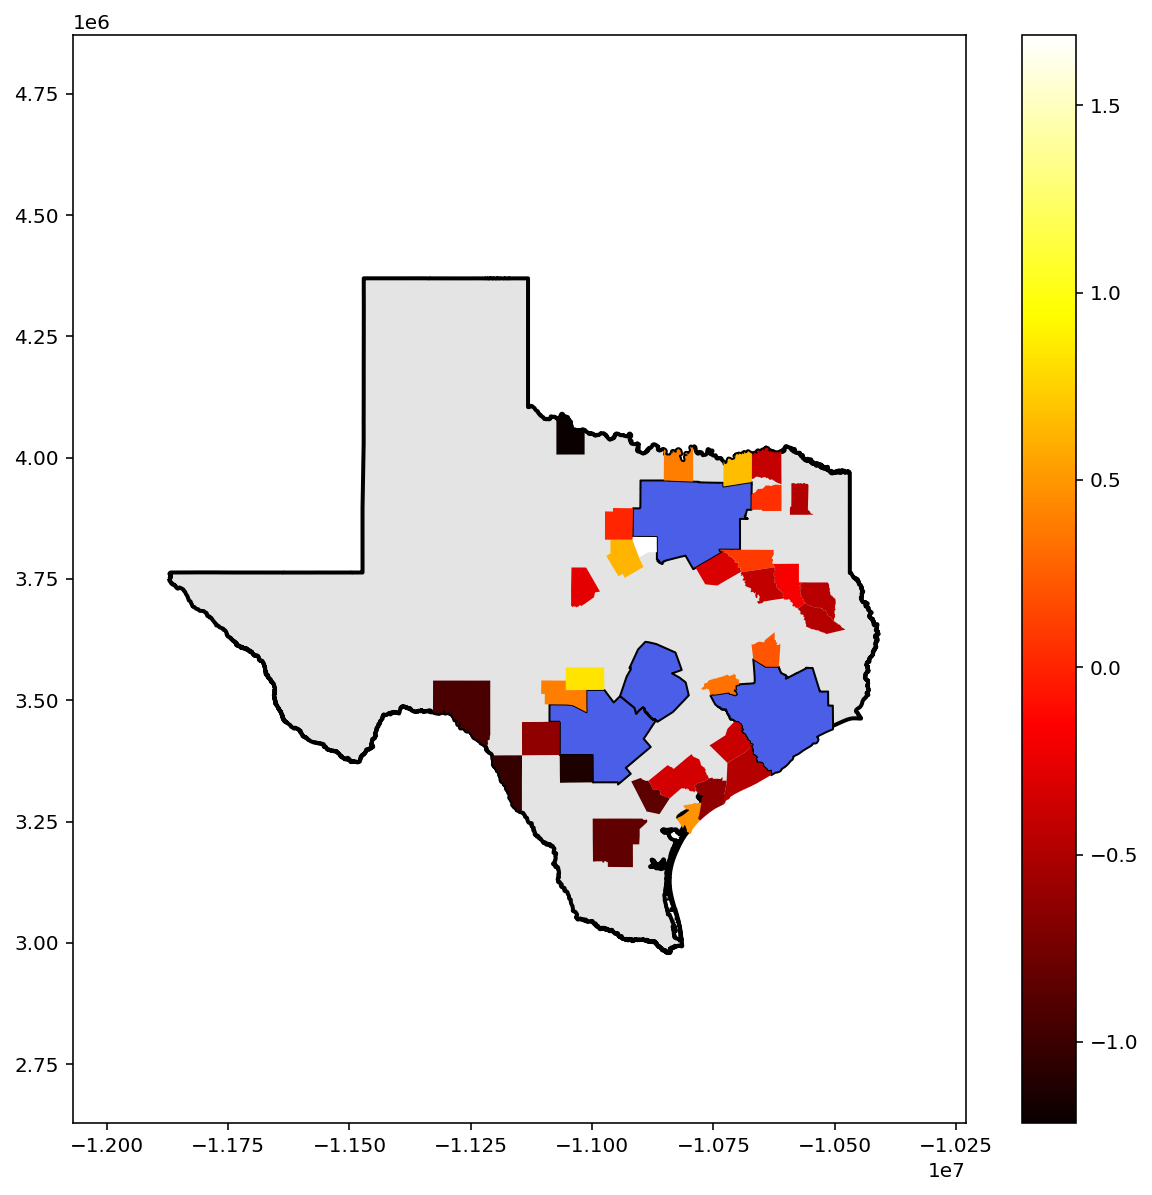

In [24]:
ax = plotTX()
df[df['metro'] & df['NAME'].str.contains(', TX')].plot(ax=ax, color="#4a5ee7", edgecolor="black", linewidth=1, label='Metro')
txLiminal = df[df['liminal'] & df['NAME'].str.contains(', TX')]
txLiminal.plot(ax=ax, column='score', cmap='hot', legend=True);

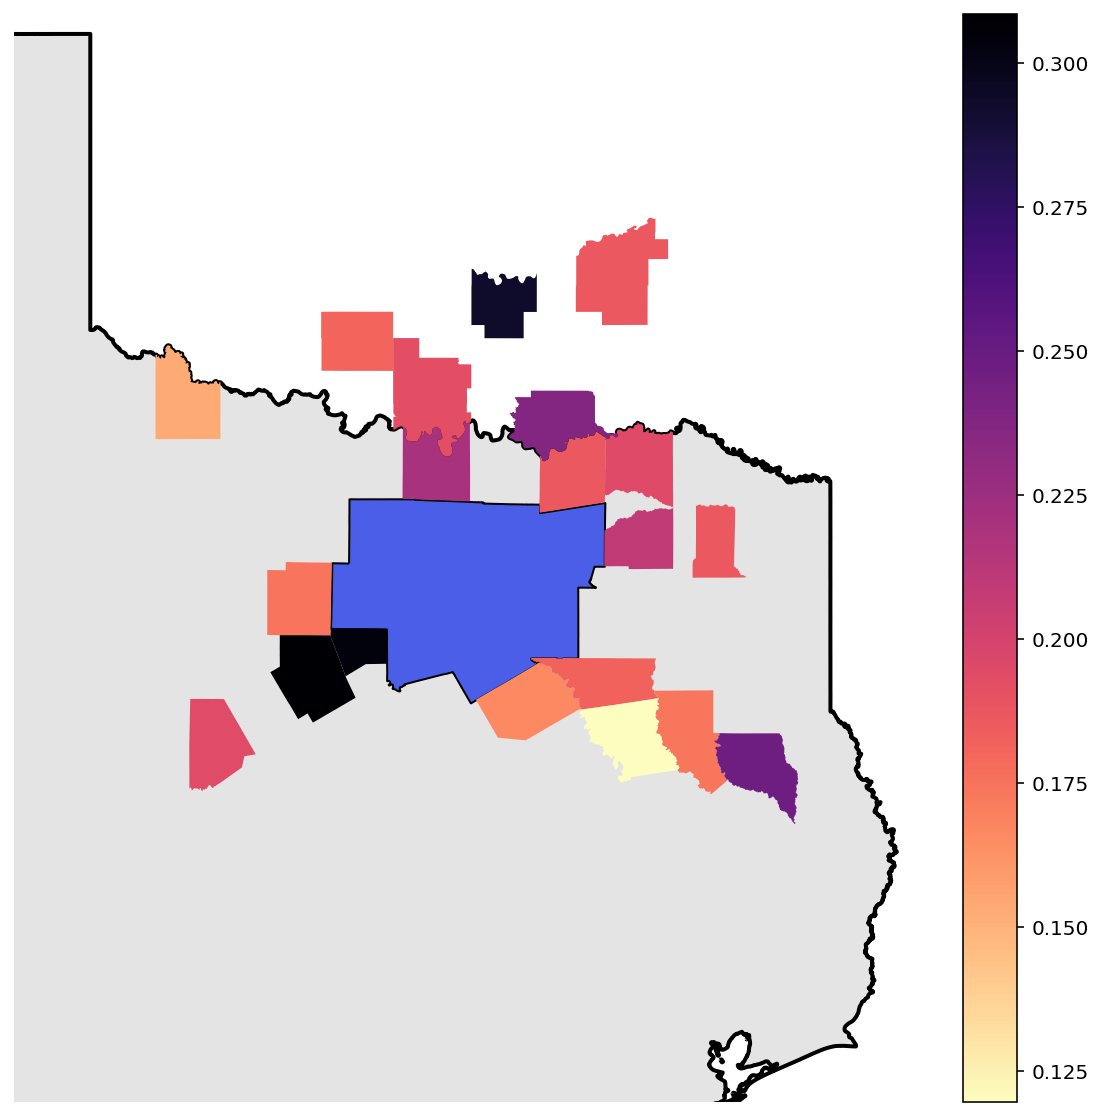

In [41]:
dfwCbsas = {10220, 11620, 11980, 14300, 15220, 18620, 20340, 20460, 23620, 24180, 27380, 32540, 33420, 34420, 34860, 37300, 37580, 44500, 44860, 46900}

ax = plotDFW()
df[df['metro'] & (df['CBSA'] == 19100)].plot(ax=ax, color="#4a5ee7", edgecolor="black", linewidth=1, label='Metro')
txLiminal = df[df['liminal'] & df['CBSA'].isin(dfwCbsas)]
txLiminal.plot(ax=ax, column='Pct_BS_Above', cmap='magma_r', legend=True);
plt.axis('off');